### Import libraries

In [639]:


!pip install plotly
!pip install shap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import shap 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler



In [640]:

data=pd.read_csv('heart.csv')
data.shape


(303, 14)

In [641]:
data.head()




,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [642]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

---
## 1.1 **Data Dictionary** <a class="anchor" id="1.1"></a>

1. age: age in years
2. sex: sex 
    * 1 = male
    * 0 = female
3. cp: chest pain type
    * Value 0: typical angina
    * Value 1: atypical angina
    * Value 2: non-anginal pain
    * Value 3: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) 
    * 1 = true; 
    * 0 = false
7. restecg: resting electrocardiographic results
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina 
    * 1 = yes
    * 0 = no
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    * Value 0: upsloping
    * Value 1: flat
    * Value 2: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 
    * 0 = `error (in the original dataset 0 maps to NaN's)`
    * 1 = fixed defect
    * 2 = normal 
    * 3 = reversable defect 
14. target (the lable): 
    * 0 = no disease, 
    * 1 = disease
---    
**Note on the target label**:

`Diagnosis of heart disease (angiographic disease status)
Value 0: < 50% diameter narrowing
Value 1: > 50% diameter narrowing`
    
**Notes from the discussion forum of the dataset**:

* data #93, 159, 164, 165 and 252 have `ca=4` which is incorrect. In the original Cleveland dataset they are NaNs.
* data #49 and 282 have `thal = 0`, also incorrect. They are also NaNs in the original dataset.

**Action**:  Drop the faulty data! (7 data entry will be dropped)

---


In [644]:
#drop the wrong ca values
data.drop(data[data['ca']  > 3].index, inplace = True)
#drop the wrong thal values
data = data[data['thal'] > 0]

data.shape



(296, 14)

In [645]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       296 non-null    int64  
 1   sex       296 non-null    int64  
 2   cp        296 non-null    int64  
 3   trestbps  296 non-null    int64  
 4   chol      296 non-null    int64  
 5   fbs       296 non-null    int64  
 6   restecg   296 non-null    int64  
 7   thalach   296 non-null    int64  
 8   exang     296 non-null    int64  
 9   oldpeak   296 non-null    float64
 10  slope     296 non-null    int64  
 11  ca        296 non-null    int64  
 12  thal      296 non-null    int64  
 13  target    296 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 34.7 KB


In [646]:
## Name column for the sake of clarity
data = data.rename(
    columns = {'cp':'chest_pain_type', 
               'trestbps':'resting_blood_pressure', 
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram', 
               'thalach': 'max_heart_rate_achieved', 
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression', 
               'slope': 'st_slope', 
               'ca':'num_major_vessels', 
               'thal': 'thalassemia'}, 
    errors="raise")

In [647]:
data['sex']= data['sex'].map({  
    1 : 'male' , 
    0 : 'female'  
})

data['chest_pain_type'] = data['chest_pain_type'].map({
    1: 'typical angina',
    2: 'atypical angina',
    3: 'non-anginal pain',
    4: 'asymptomatic'
})

data['fasting_blood_sugar'] = data['fasting_blood_sugar'].map({
    0: 'lower than 120mg/ml',
    1: 'greater than 120mg/ml'
})

data['resting_electrocardiogram'] = data['resting_electrocardiogram'].map({
    0: 'normal',
    1: 'ST-T wave abnormality',
    2: 'left ventricular hypertrophy'
})

data['exercise_induced_angina'] = data['exercise_induced_angina'].map({
    0: 'no',
    1: 'yes'
})

data['st_slope'] = data['st_slope'].map({
    0: 'upsloping',
    1: 'flat',
    2: 'downsloping'
})

data['thalassemia'] = data['thalassemia'].map({
    1: 'fixed defect',
    2: 'normal',
    3: 'reversable defect'
})






In [648]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,upsloping,0,fixed defect,1
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,upsloping,0,normal,1
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,downsloping,0,normal,1
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,downsloping,0,normal,1
4,57,female,NaN,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,downsloping,0,normal,1


In [649]:
data.dtypes

age                            int64
sex                           object
chest_pain_type               object
resting_blood_pressure         int64
cholesterol                    int64
fasting_blood_sugar           object
resting_electrocardiogram     object
max_heart_rate_achieved        int64
exercise_induced_angina       object
st_depression                float64
st_slope                      object
num_major_vessels              int64
thalassemia                   object
target                         int64
dtype: object

### Grouping Features (by data type)

In [651]:
# numerical fearures 6

num_feats = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']
# categorical (binary)
bin_feats = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']
# caterorical (multi-)
nom_feats= ['chest_pain_type', 'resting_electrocardiogram', 'st_slope', 'thalassemia']
cat_feats = nom_feats + bin_feats



### Exploring Features/Target

In [653]:
data['target'].value_counts() * 100 / data.shape[0] 

target
1    54.054054
0    45.945946
Name: count, dtype: float64

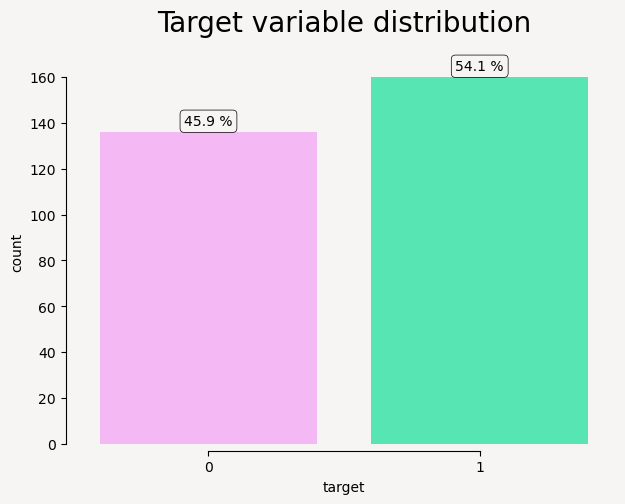

In [654]:
##Target distribution

mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

plt.figure(figsize=(7, 5),facecolor='#F6F5F4')
total = float(len(data))
ax = sns.countplot(x='target', data=data, hue='target', palette=mypal[1::4], legend=False)


ax.set_facecolor('#F6F5F4')

for p in ax.patches:
    
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Target variable distribution', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

In [655]:
##Numerical Features
data[num_feats].describe().T



,count,mean,std,min,25%,50%,75%,max
age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
cholesterol,296.0,247.155405,51.977011,126.0,211.0,242.5,275.25,564.0
resting_blood_pressure,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
max_heart_rate_achieved,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
st_depression,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2
num_major_vessels,296.0,0.679054,0.939726,0.0,0.0,0.0,1.00,3.0


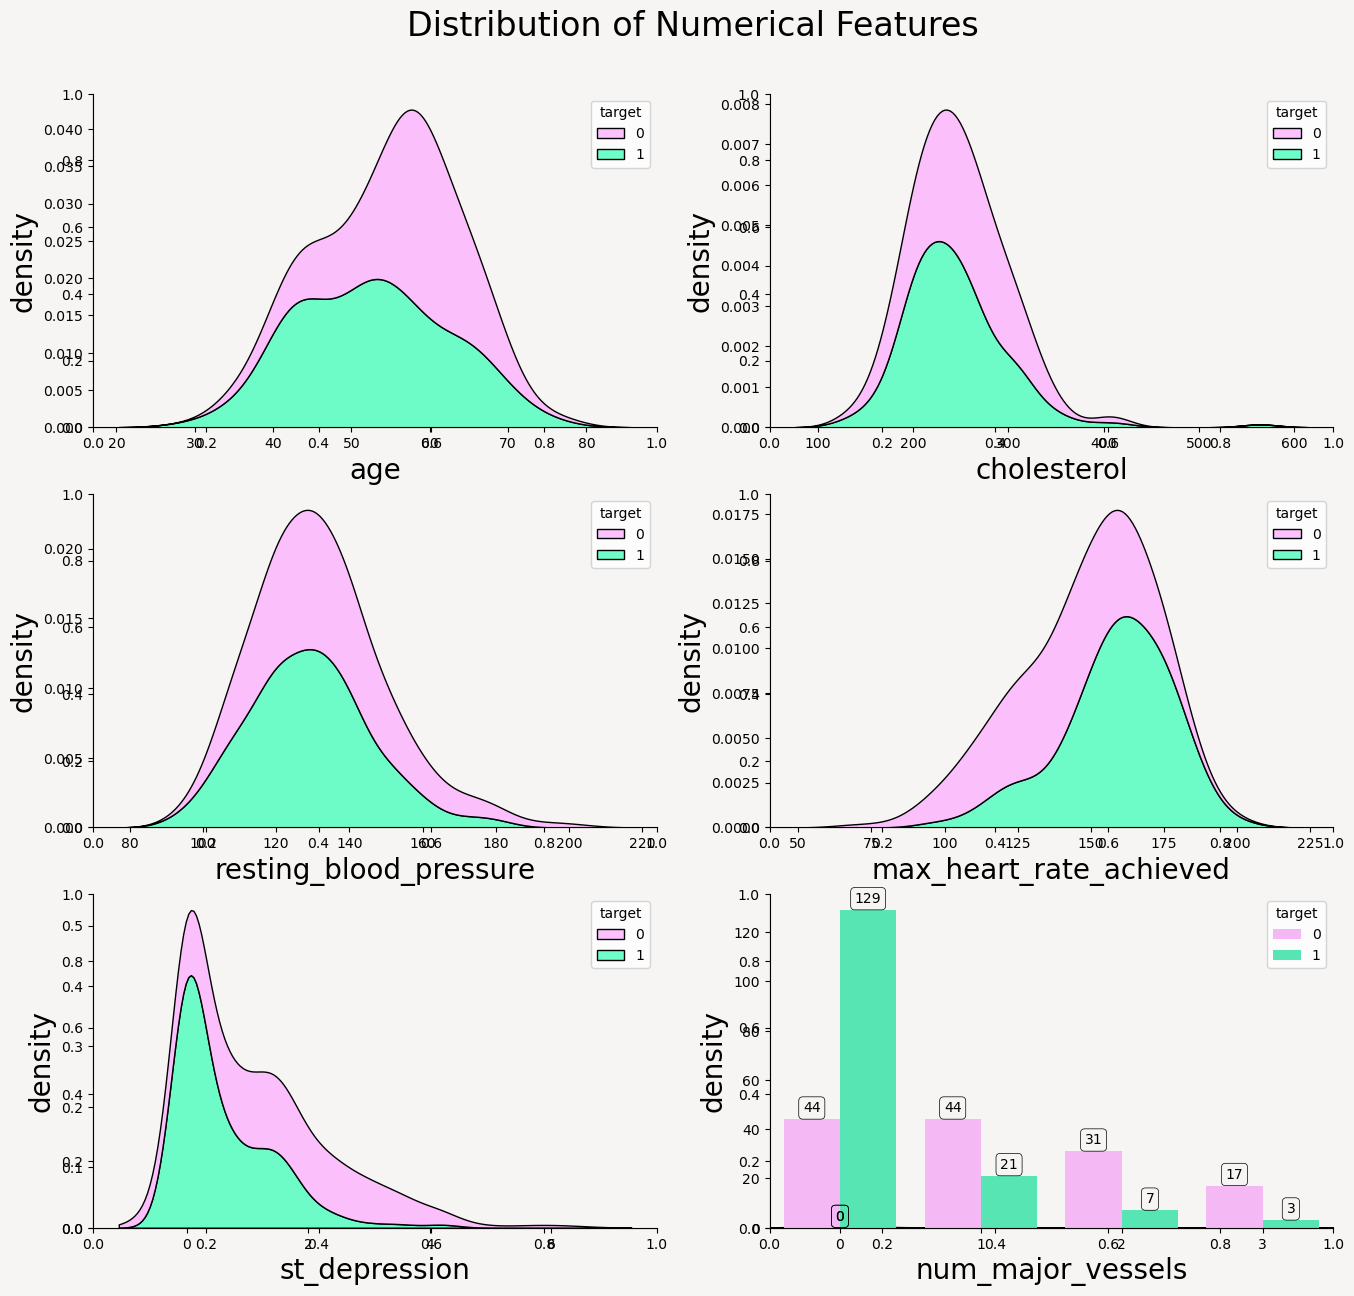

In [656]:
L = len(num_feats)
ncol= 2
nrow= int(np.ceil(L/ncol))
remove_last= (nrow * ncol) - L

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='#F6F5F4')   
fig.subplots_adjust(top=0.92)

i = 1
for col in num_feats:
    plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
    
    ax = sns.kdeplot(data=data, x=col, hue="target", multiple="stack", palette=mypal[1::4]) 
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)
    
    if col == 'num_major_vessels':
        sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4])
        for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
    
    i = i +1
plt.suptitle('Distribution of Numerical Features' ,fontsize = 24);

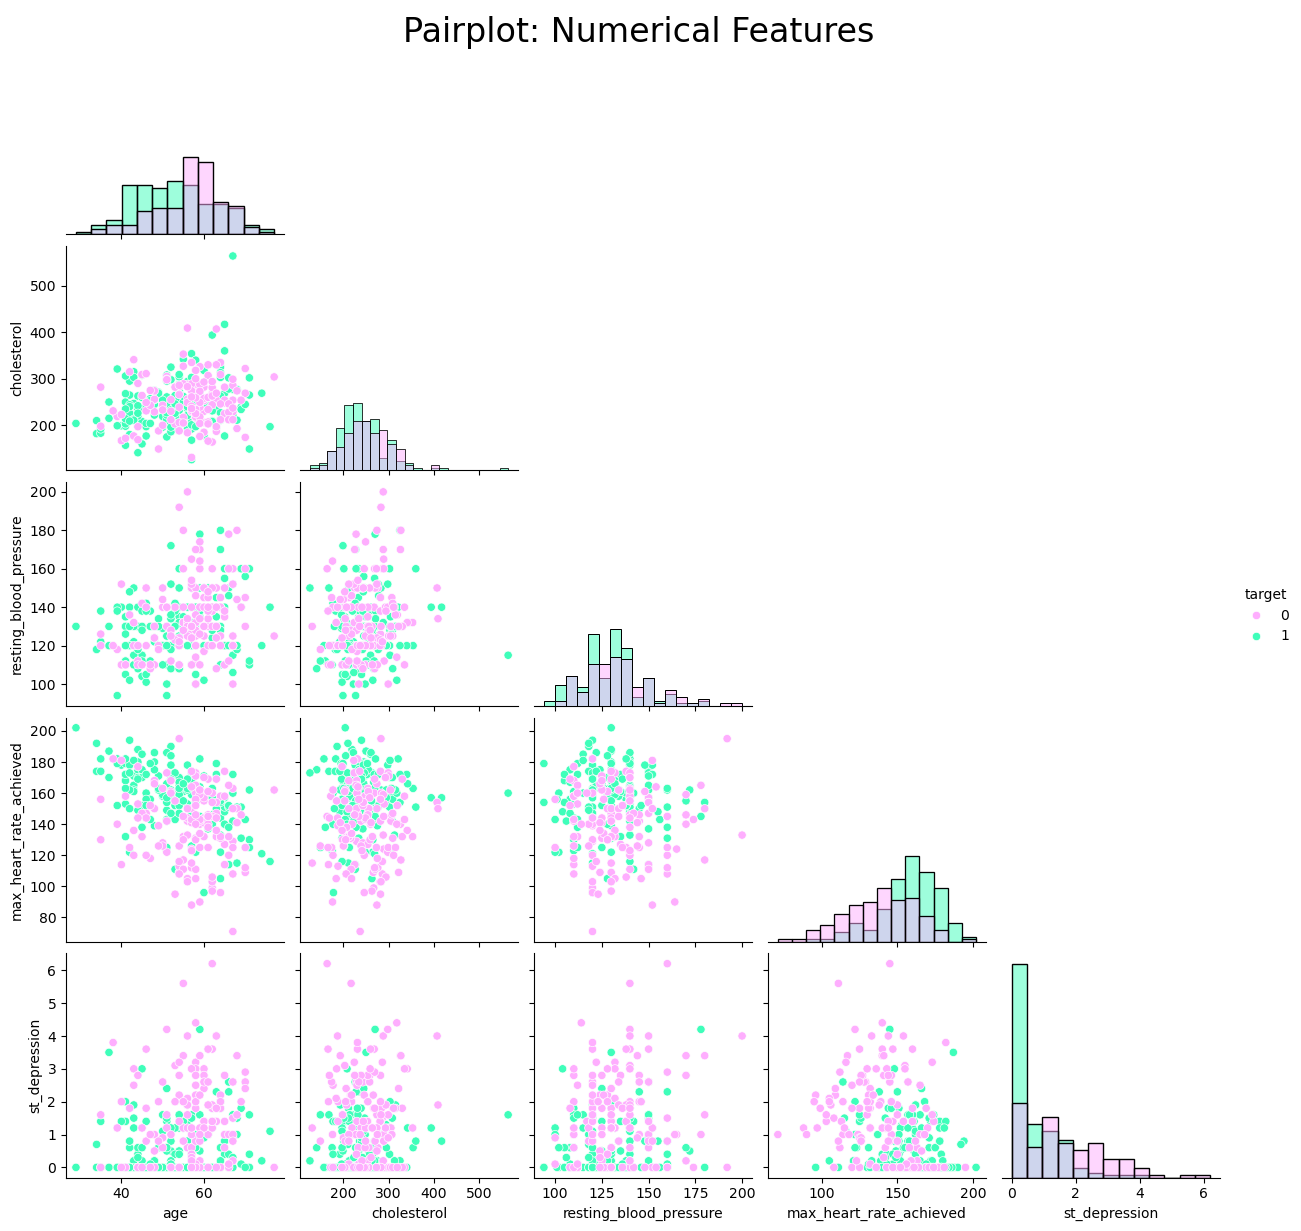

In [657]:
_ = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'target']
data_ = data[_]
g = sns.pairplot(data_, hue="target", corner=True, diag_kind='hist', palette=mypal[1::4]);
plt.suptitle('Pairplot: Numerical Features ' ,fontsize = 24);

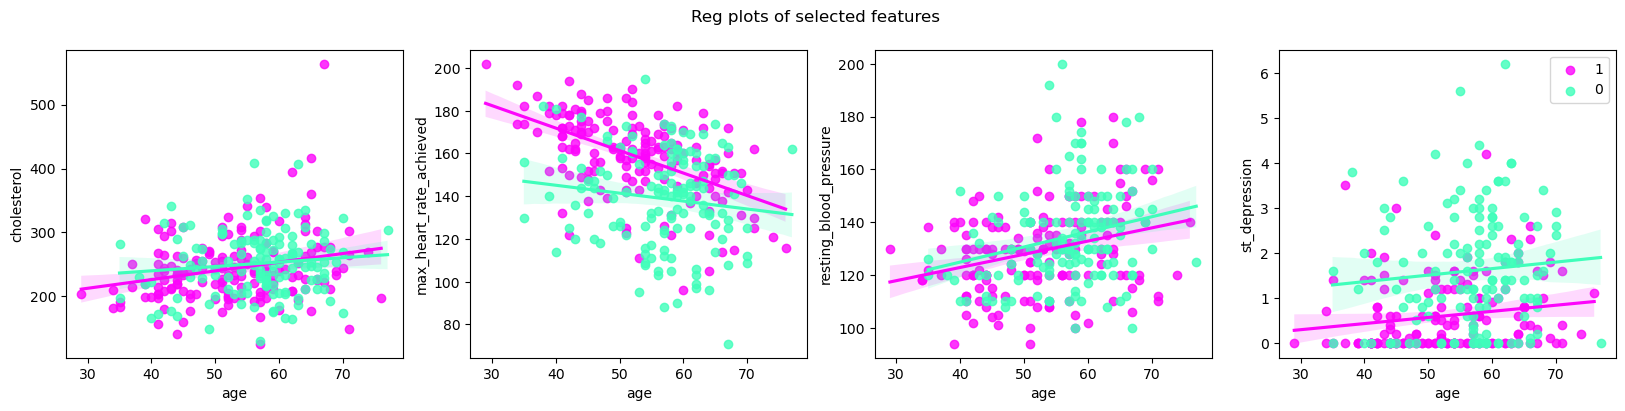

In [658]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))
sns.regplot(data=data[data['target'] ==1], x='age', y='cholesterol', ax = ax[0], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='cholesterol', ax = ax[0], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='max_heart_rate_achieved', ax = ax[1], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='max_heart_rate_achieved', ax = ax[1], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='resting_blood_pressure', ax = ax[2], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='resting_blood_pressure', ax = ax[2], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='st_depression', ax = ax[3], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='st_depression', ax = ax[3], color=mypal[5], label='0')
plt.suptitle('Reg plots of selected features')
plt.legend();

### Categorical Features

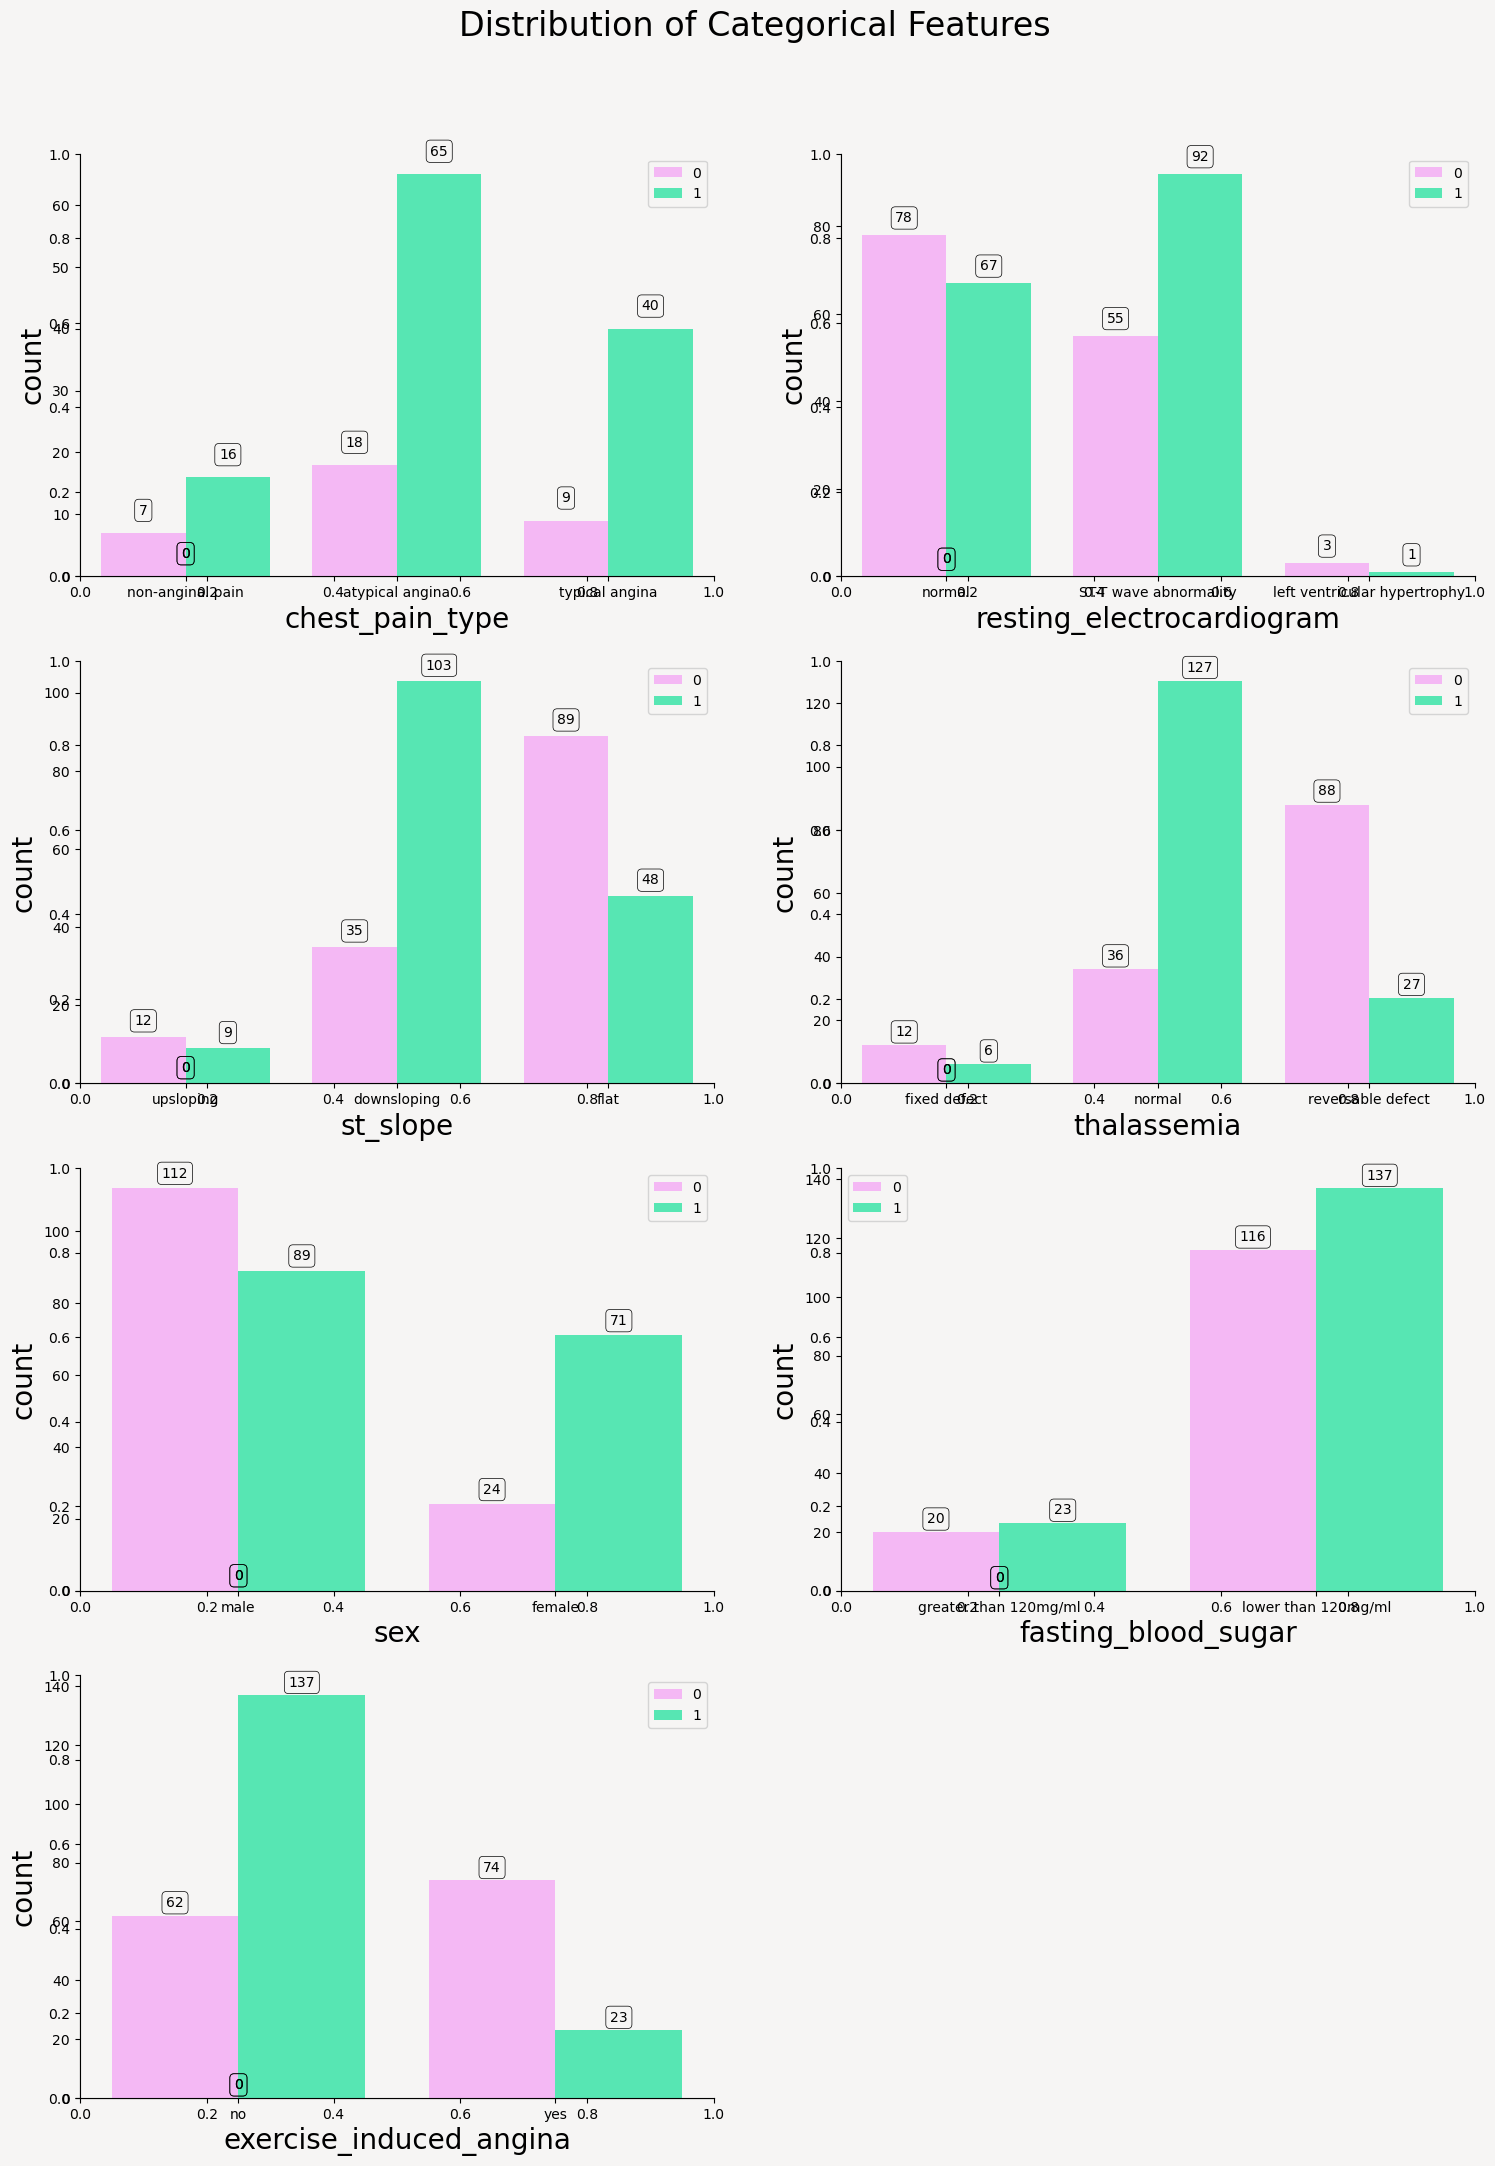

In [660]:
def count_plot(data, cat_feats):    
    L = len(cat_feats)
    ncol= 2
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(18, 24), facecolor='#F6F5F4')    
    fig.subplots_adjust(top=0.92)
    ax.flat[-remove_last].set_visible(False)

    i = 1
    for col in cat_feats:
        plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
        ax = sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4])
        ax.set_xlabel(col, fontsize=20)
        ax.set_ylabel("count", fontsize=20)
        sns.despine(right=True)
        sns.despine(offset=0, trim=False) 
        plt.legend(facecolor='#F6F5F4')
        
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                  bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
        
        i = i +1

    plt.suptitle('Distribution of Categorical Features' ,fontsize = 24)
    return 0

count_plot(data, cat_feats[0:-1]);



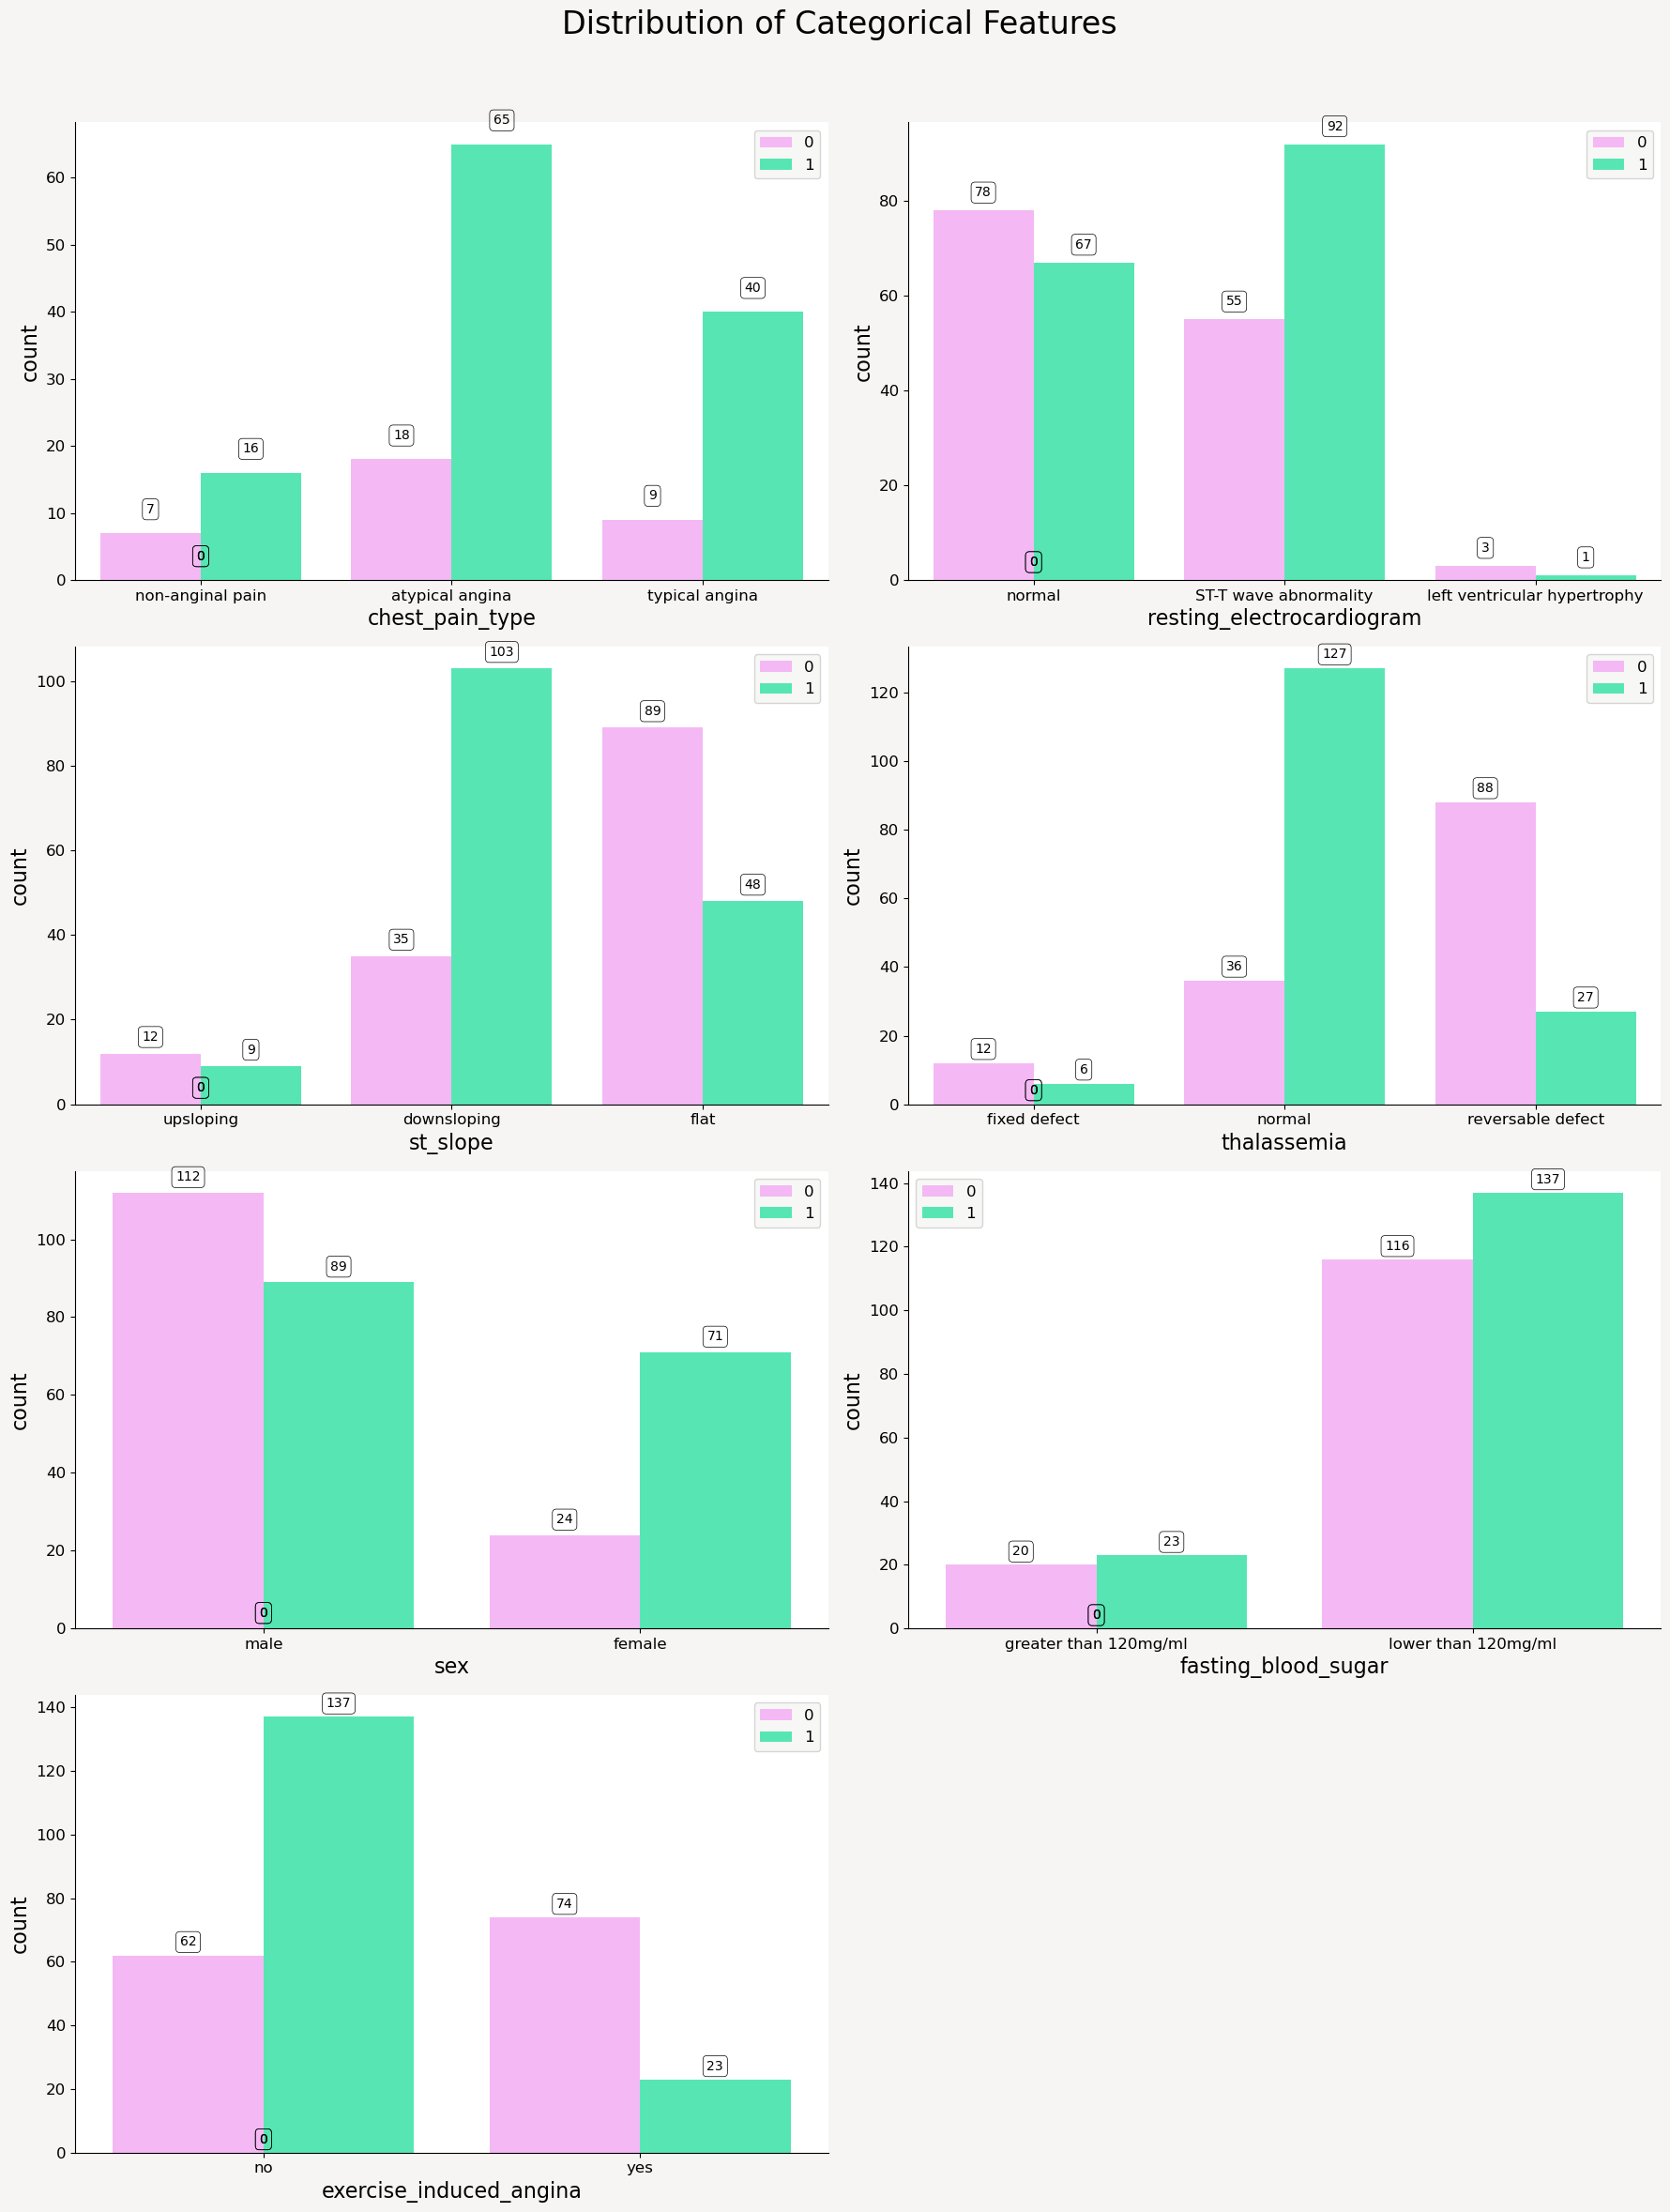

In [661]:
def count_plot(data, cat_feats):    
    L = len(cat_feats)
    ncol = 2
    nrow = int(np.ceil(L / ncol))
    remove_last = (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol, figsize=(18, 24), facecolor='#F6F5F4')    
    fig.subplots_adjust(top=0.92)

    # Hide extra empty subplots
    if remove_last > 0:
        for i in range(1, remove_last + 1):
            ax.flat[-i].set_visible(False)

    for i, col in enumerate(cat_feats):
        current_ax = ax.flat[i]
        sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4], ax=current_ax)
        current_ax.set_xlabel(col, fontsize=16)
        current_ax.set_ylabel("count", fontsize=16)
        current_ax.tick_params(axis='x', labelrotation=0)
        current_ax.tick_params(axis='both', labelsize=12)
        sns.despine(ax=current_ax, right=True)
        current_ax.legend(facecolor='#F6F5F4', fontsize=12)

        for p in current_ax.patches:
            height = p.get_height()
            current_ax.text(p.get_x() + p.get_width() / 2., height + 3,
                            '{:1.0f}'.format(height), ha="center",
                            bbox=dict(facecolor='none', edgecolor='black',
                                      boxstyle='round', linewidth=0.5))

    fig.suptitle('Distribution of Categorical Features', fontsize=24)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    return 0

count_plot(data, cat_feats[0:-1]);


###Pearson's correlation

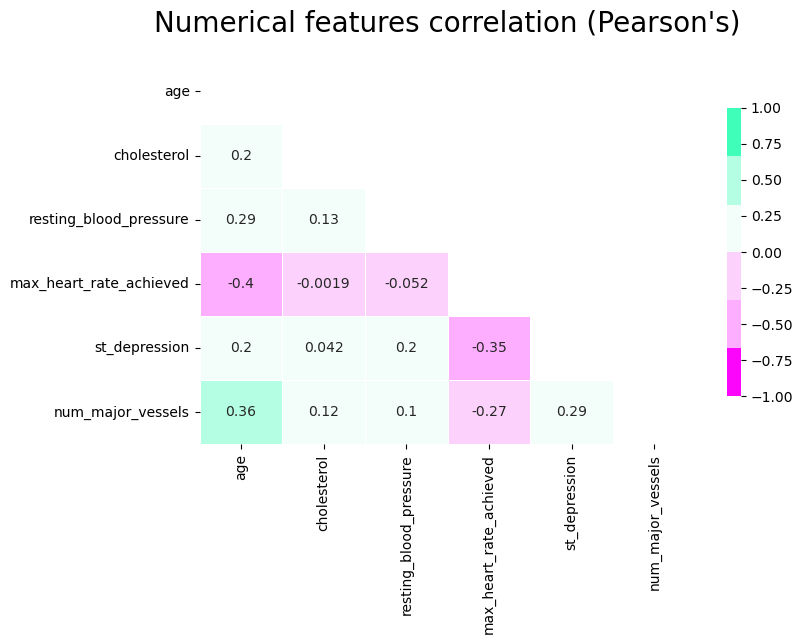

In [663]:
df_ = data[num_feats]
corr = df_.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Numerical features correlation (Pearson's)", fontsize=20, y= 1.05);

###Point biserial correlation

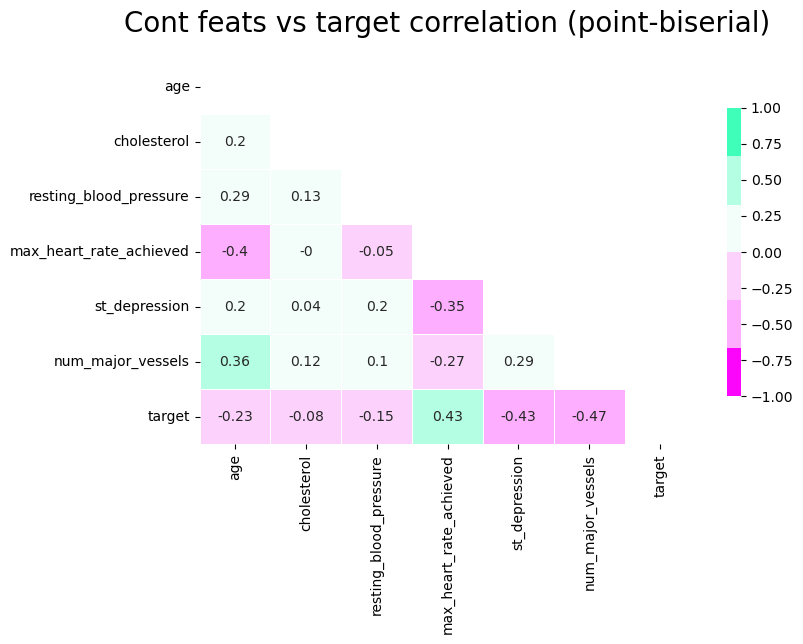

In [665]:


feats_ = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels', 'target']

def point_biserial(x, y):
    pb = stats.pointbiserialr(x, y)
    return pb[0]

rows= []
for x in feats_:
    col = []
    for y in feats_ :
        pbs =point_biserial(data[x], data[y]) 
        col.append(round(pbs,2))  
    rows.append(col)  
    
pbs_results = np.array(rows)
DF = pd.DataFrame(pbs_results, columns = data[feats_].columns, index =data[feats_].columns)

mask = np.triu(np.ones_like(DF, dtype=bool))
corr = DF.mask(mask)

f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Cont feats vs target correlation (point-biserial)", fontsize=20, y= 1.05);

### Cramer's V correlation

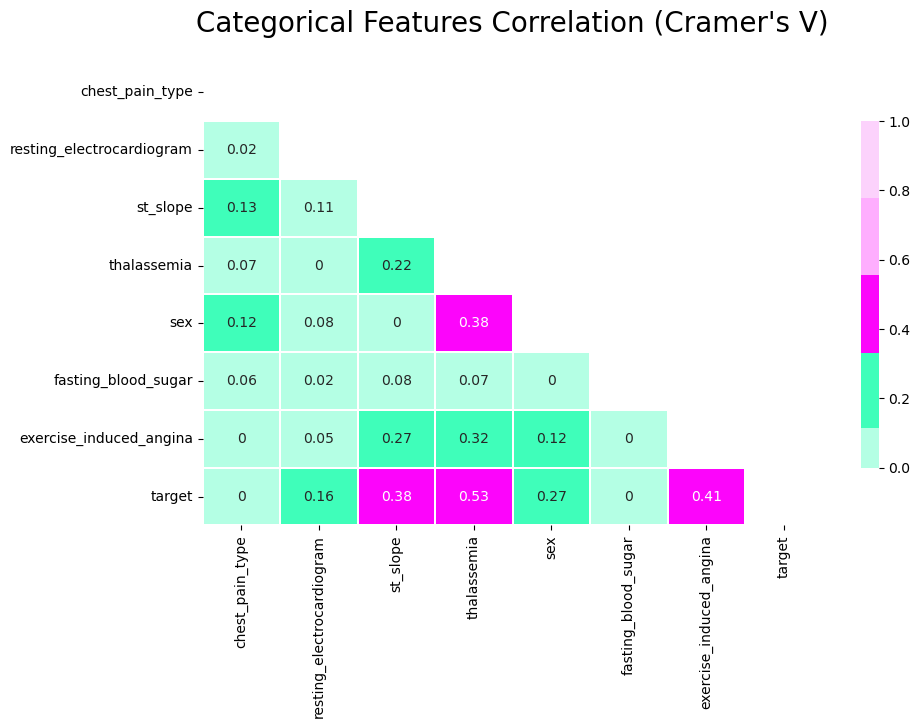

In [667]:
def cramers_v(x, y): 
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# calculate the correlation coefficients using the above function
data_ = data[cat_feats]
rows= []
for x in data_:
    col = []
    for y in data_ :
        cramers =cramers_v(data_[x], data_[y]) 
        col.append(round(cramers,2))
    rows.append(col)
    
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_.columns, index = data_.columns)

# color palette 
mypal_1= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA', '#FC05FB', '#FEAEFE', '#FCD2FC']
# plot the heat map
mask = np.triu(np.ones_like(df, dtype=bool))
corr = df.mask(mask)
f, ax = plt.subplots(figsize=(10, 6), facecolor=None)
cmap = sns.color_palette(mypal_1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Categorical Features Correlation (Cramer's V)", fontsize=20, y= 1.05);

## **1.5 EDA Summary**: <a class="anchor" id="1.5"></a>

* Data size: 303 rows and 14 columns (13 independent + one target variable) > later reduced to 296 after removing faulty data points!
* Data has no missing values
* Features (columns) data type: 
    * Six features are numerical 
    * The rest (seven features) are categorical variables
* Target variable is fairly balanced, 54% no-disease to 46% has-disease
* Correlations:
    * Correlation between features is weak at best
    * From the numerical features `num_major_vessels`, `max_heart_rate_achieved` and `st_depression` are reasonabily fairly correlated with the target variable at -0.47, 0.43 and -0.43 correlation coefficient respectively.
    * From the categorical features `chest_pain_type`, `num_major_vessels`, `thalassemia`, and `exercise_induced_angina` are better correlated with the target variable, `thalassemia` being the highest at 0.52.
    * Cholestrol (to my surprize, but what do I know?) has less correlation with heart desease. 
    
**Takeaway**: features that have higher predictive power could be, **`chest_pain_type`, `num_major_vessels`, `thalassemia`, `exercise_induced_angina` `max_heart_rate_achieved`** and **`st_depression`**. We will see which features will appear as imporatnt by the classification models.
           

### Predictions

In [670]:

def score_summary(names, classifiers):
 
    
    cols=["Classifier", "Accuracy", "ROC_AUC", "Recall", "Precision", "F1"]
    rows = []
    data_table = pd.DataFrame(columns=cols)
    
    for name, clf in zip(names, classifiers):        
        clf.fit(X_train, y_train)
        
        pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val, pred)

        pred_proba = clf.predict_proba(X_val)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)        
        roc_auc = auc(fpr, tpr)
        
        # confusion matric, cm
        cm = confusion_matrix(y_val, pred) 
        
        # recall: TP/(TP+FN)
        recall = cm[1,1]/(cm[1,1] +cm[1,0])
        
        # precision: TP/(TP+FP)
        precision = cm[1,1]/(cm[1,1] +cm[0,1])
        
        # F1 score: TP/(TP+FP)
        f1 = 2*recall*precision/(recall + precision)

        rows.append([name, accuracy * 100, roc_auc, recall, precision, f1])
    print(rows)

    data_table = pd.DataFrame(rows, columns=cols)

    return(np.round(data_table.reset_index(drop=True), 2))

def plot_metrics(df):
    df = score_summary(names, classifiers).sort_values(by='Accuracy', ascending=False)

    df.set_index("Classifier")[["ROC_AUC", "Recall", "Precision", "F1"]].plot(kind='bar', figsize=(10,6))
    
    plt.title("Classifier Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    
    # Add horizontal grid lines
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


def plot_conf_matrix(names, classifiers, nrows=4, ncols=3, fig_a=12, fig_b=12):
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_a, fig_b))
    axes = axes.flatten()
    for idx, (name, clf) in enumerate(zip(names, classifiers)):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(name)
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')


    plt.tight_layout()
    plt.show()




    
    
def roc_auc_curve(names, classifiers):
      
    plt.figure(figsize=(12, 8))   
        
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        
        pred_proba = clf.predict_proba(X_val)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")



                

### split the data into train and test sets

In [672]:

cat_features = cat_feats
data = label_encode_cat_features(data, cat_features)
features = data.columns[:-1]
X = data[features]
y = data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



names = [
    'Logistic Regression',
    'Nearest Neighbors',
    'Support Vectors',
    'Nu SVC',
    'Decision Tree',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Naive Bayes',
    'Linear DA',
    'Quadratic DA',

]

classifiers = [
    LogisticRegression(solver="liblinear", random_state=0),
    KNeighborsClassifier(2),
    SVC(probability=True, random_state=0),
    NuSVC(probability=True, random_state=0),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    AdaBoostClassifier(algorithm='SAMME', random_state=0),
    GradientBoostingClassifier(random_state=0),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),

]


### Performance metrics summary table

[['Logistic Regression', 83.78378378378379, 0.9362637362637363, 0.8857142857142857, 0.7948717948717948, 0.8378378378378378], ['Nearest Neighbors', 55.4054054054054, 0.5989010989010989, 0.3142857142857143, 0.55, 0.4], ['Support Vectors', 64.86486486486487, 0.8043956043956044, 0.8857142857142857, 0.5849056603773585, 0.7045454545454545], ['Nu SVC', 82.43243243243244, 0.9406593406593406, 0.9428571428571428, 0.75, 0.8354430379746834], ['Decision Tree', 82.43243243243244, 0.8245421245421245, 0.8285714285714286, 0.8055555555555556, 0.8169014084507044], ['Random Forest', 83.78378378378379, 0.926007326007326, 0.8571428571428571, 0.8108108108108109, 0.8333333333333334], ['AdaBoost', 85.13513513513513, 0.9326007326007325, 0.8857142857142857, 0.8157894736842105, 0.8493150684931505], ['Gradient Boosting', 78.37837837837837, 0.9010989010989011, 0.8, 0.7567567567567568, 0.7777777777777778], ['Naive Bayes', 82.43243243243244, 0.9362637362637363, 0.8571428571428571, 0.7894736842105263, 0.82191780821917

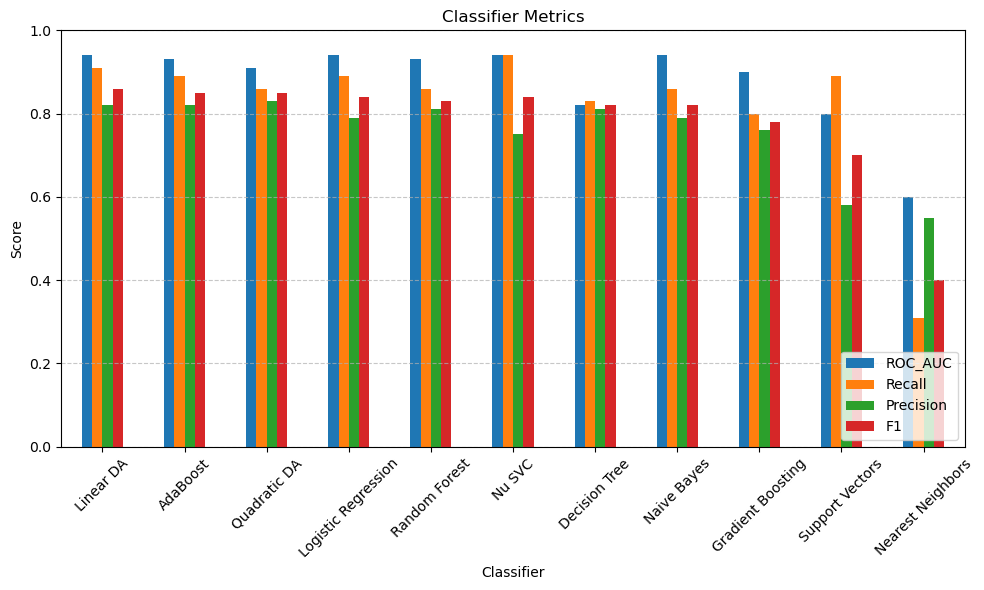

In [674]:

df=score_summary(names, classifiers)
plot_metrics(df)


### Confusion matrix

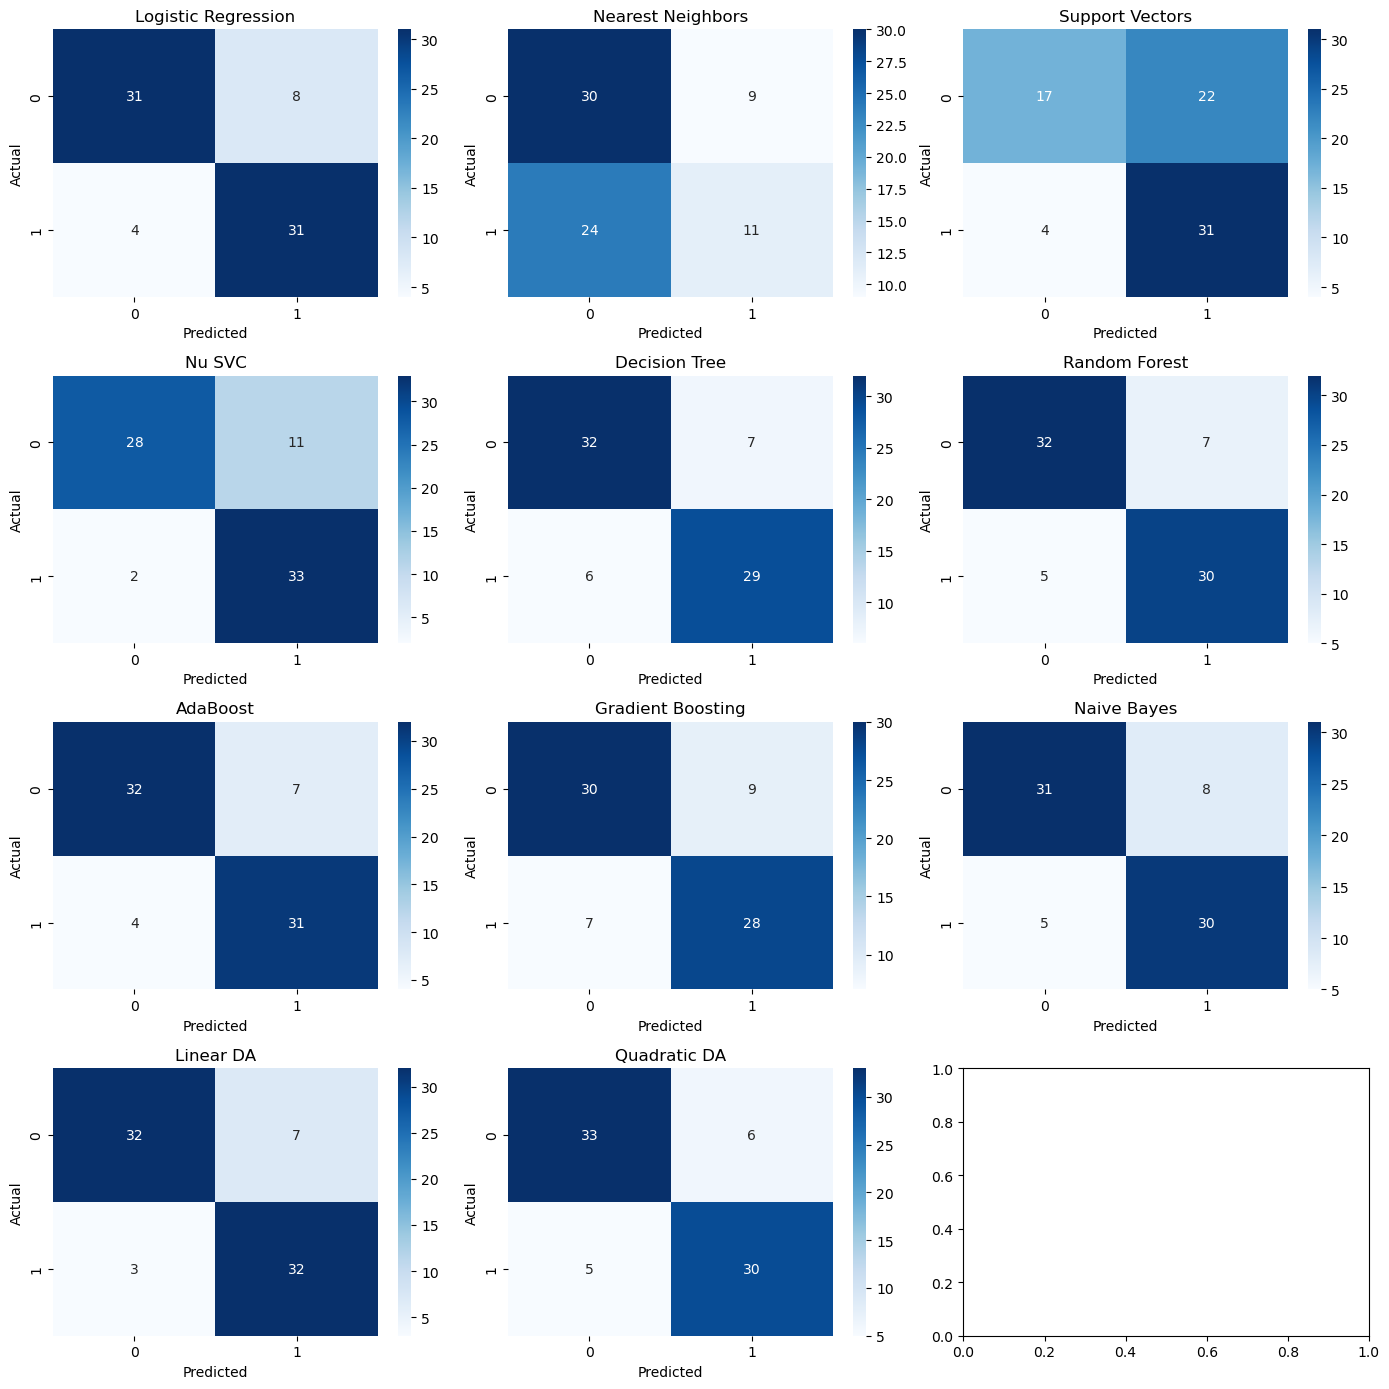

In [676]:
plot_conf_matrix(names, classifiers, nrows=4, ncols=3, fig_a=14, fig_b=14)

### ROC curves

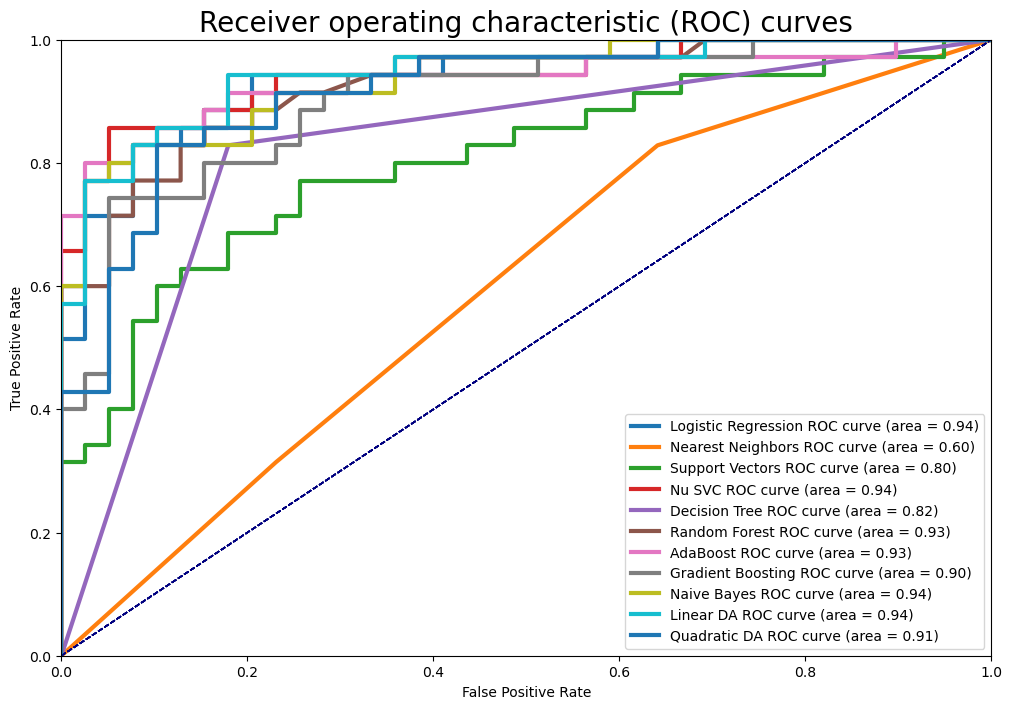

In [678]:
roc_auc_curve(names, classifiers)

### Now that we’ve reviewed all the performance metrics of the classifiers, it’s time to decide on the best-performing algorithm. While QDA ranks first in precision (85%), Logistic Regression (LR) has the highest F1-score (86%), which provides a balanced measure of both precision and recall. Since F1-score is often the most reliable metric when we need to balance false positives and false negatives, we select Logistic Regression as the best classifier for our problem.

### Parameter Tuning (RandomizedSearch): LogisticRegression

In [681]:


lr = LogisticRegression(random_state=42, max_iter=1000)

param_dist = {
    'C': uniform(loc=0.01, scale=10),  # Continuous values for regularization strength
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Only solver that supports both l1 and l2
}

search = RandomizedSearchCV(
    lr,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=5

)

# Fit on your training data
search.fit(X_train, y_train)





# Best hyperparameters
print("Best Parameters:", search.best_params_)

Best Parameters: {'C': 1.3152818704236402, 'penalty': 'l2', 'solver': 'liblinear'}


In [682]:
params = search.best_params_
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)
print(classification_report(y_val, lr.predict(X_val)))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84        39
           1       0.79      0.89      0.84        35

    accuracy                           0.84        74
   macro avg       0.84      0.84      0.84        74
weighted avg       0.84      0.84      0.84        74



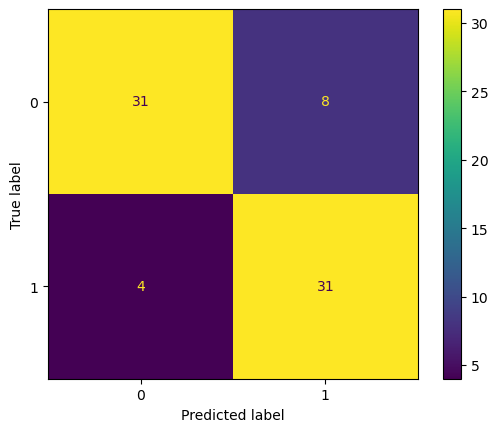

In [683]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(search, X_val, y_val)

### Remark : It turns out that our base model (default params) is not bad at all. Parameter tuning did not help to further increase the performance.